# Disaster Response
# NLP Pipeline Preparation / ML Model
This notebook provide a detailed description of the process of preparing messages so that they can be processed by a classifier model (NLP pipeline).  
It also covers the creation of the model, which will be chosen among several candidates.

All functions and preparation will be implemented in a python file.

### 1. Import libraries and load database.
- Import Python libraries
- Load data from the database.

In [11]:
# import libraries
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
# from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.base import BaseEstimator
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support
import pickle
from tqdm import tqdm

RS = 42

In [2]:
# load data from database
def load_data():
    '''
    Load data from the database
    OUTPUT
    X Array(str): Array with messages
    y Array(int): Array with the category of each message hot coded (1,0,0,0...)
    category_names panda indexes: Names of the category
    '''
    engine = create_engine('sqlite:///data/DisasterResponse.db')
    df = pd.read_sql_table('Disaster_Resp',con=engine)
    X = df['message'].values
    y = df.drop(['id','message','genre'],axis=1)
    empty_categories = y.columns[y.sum() ==0].values
    y = y.drop(empty_categories,axis=1)
    category_names = y.columns
    y = y.values
    return X, y, category_names

X, y, category_names = load_data()

**Class Balance**   
We can see that the classes are not balanced. We will have to take this into account when building the model.

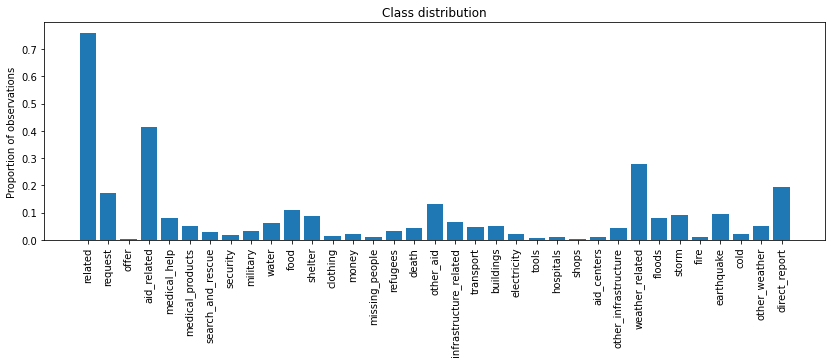

In [3]:
plt.figure(figsize=(14,4))
plt.bar(x = category_names,height = np.sum(y,axis=0)/y.shape[0])
plt.xticks(rotation=90)
plt.title('Class distribution')
plt.ylabel('Proportion of observations')
plt.show()

### 2. Write a tokenization function to process data

In [4]:
def tokenize(text):
    '''
    tokenize
    Tokenize the text, removing web addresses, upper case, and anything 
    but letters and digits. 
    Split sentences into list of words.
    Remove stop words and converts verbs into infinitive.
    
    Input:
    text:   message from the data set

    Returns:
    tokens:     list of tokenized words
    '''
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex, " ", text.lower())
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word, pos = 'v') for word in tokens]
    return tokens

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

### 3. Write a score function that returns precision, recall and f1 score as a pandas DataFrame

In [6]:
def score(y_true, y_pred, index):
    '''
    Calculate precision, recall and f1 score
    Input: 
    y_true: True labels of the data
    y_pred: Predictions made by our model
    index str: The index to be given to the predictions in the output dataframe
    Output:
    df DataFrame: A dataframe with the three metrics calculated
    '''
    metrics = precision_recall_fscore_support(y_true, y_pred, average='weighted', zero_division=True)
    performance = {'precision':metrics[0], 'recall':metrics[1], 'f1':metrics[2]}
    return pd.DataFrame(performance, index = [index])
scores = pd.DataFrame()

### 4. Build a class to sitch between models
We compare 7 models:
1. Logistic regression
2. Stochastic gradient descent (SGD)
3. Linear support vector machine (SVM)
4. K-nearest neighbors (KNN)
5. Random forest
6. Extreme gradient boosting (XGBoost)
7. Light Gradient Boosting Machine (LightGBM)

Some of these models do not support multi-label classification, so we will pass them to `MultiOutputClassifier`.

To correct for class imbalance we will use non-uniform class weighting whenever possible. 

As for the TfidfVectorizer, we will test an n-gram of values (1,1) and (1,2).

To make it easier to compare various models, we will use a class (`ClfSwitcher`) that inherits the `fit()`, `predict()`, `predict_proba()` and `score()` methods from scikit-learn `BaseEstimator`.

In [7]:
class ClfSwitcher(BaseEstimator):
    
    def __init__(self, estimator=RandomForestClassifier()):
        """
        A Custom BaseEstimator that can switch between classifiers.
        
        Parameters
        ----------
        estimator: sklearn object, the classifier
        """
        self.estimator = estimator
    
    def fit(self, X, y):
        self.estimator.fit(X, y)
        return self
    
    def predict(self, X):
        return self.estimator.predict(X)
    
    def predict_proba(self, X):
        return self.estimator.predict_proba(X)
    
    def score(self, X, y):
        return self.estimator.score(X, y)

In [8]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize)),
    ('clf', ClfSwitcher())
])

In [9]:
grid = ParameterGrid({
    'clf__estimator': [
        MultiOutputClassifier(LogisticRegression(class_weight='balanced', random_state=RS), n_jobs=-1),
        MultiOutputClassifier(SGDClassifier(class_weight='balanced', random_state=RS, loss='modified_huber'), n_jobs=-1),
        MultiOutputClassifier(LinearSVC(class_weight='balanced', random_state=RS), n_jobs=-1),
        KNeighborsClassifier(n_jobs=-1),
        RandomForestClassifier(class_weight='balanced', random_state=RS, n_jobs=-1),
        XGBClassifier(scale_pos_weight=(1-y_train.mean())/y_train.mean(), random_state=RS, n_jobs=-1),
        MultiOutputClassifier(LGBMClassifier(is_unbalance=True, random_state=RS), n_jobs=-1)
    ],
    'tfidf__ngram_range': [(1,1), (1,2)]
})

models = [
    'logreg1', 'logreg2','sgd1', 'sgd2', 'svm1', 'svm2',
      'knn1', 'knn2', 'rf1', 'rf2', 'xgb1', 'xgb2', 'lgbm1', 'lgbm2'
]

In [10]:
for model, params in tqdm(zip(models, grid), total=len(models)):
    pipeline.set_params(**params)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    machine_learning = score(y_test, y_pred, model)
    scores = pd.concat([scores, machine_learning])
    
scores.sort_values('f1', ascending=False)

 43%|███████████████████████████████████▌                                               | 6/14 [02:15<02:45, 20.66s/it]C:\Users\pingw\anaconda3\envs\tf\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
 50%|█████████████████████████████████████████▌                                         | 7/14 [02:36<02:23, 20.54s/it]C:\Users\pingw\anaconda3\envs\tf\lib\site-packages\sklearn\neighbors\_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically

,precision,recall,f1
sgd2,0.653368,0.720317,0.682563
svm2,0.667736,0.698694,0.679686
logreg2,0.619368,0.752831,0.671666
logreg1,0.629170,0.732115,0.664859
lgbm1,0.633945,0.722961,0.663849
lgbm2,0.633049,0.715267,0.662455
xgb2,0.574612,0.769483,0.649242
sgd1,0.621585,0.692262,0.648376
xgb1,0.564732,0.785937,0.647898
svm1,0.627408,0.673914,0.646606


### 5. Stacking models
The best models based un f1 score are SGD, SVM and Logistic Regression, all of them using n-gram(1,2).  
Let's stack this three models using `StackingClassifier`.


In [11]:
stack = MultiOutputClassifier(
    StackingClassifier([
        ('logreg2', LogisticRegression(class_weight='balanced', random_state=RS)),
        ('sgd2',SGDClassifier(class_weight='balanced', random_state=RS, loss='modified_huber')),
        ('svm2', LinearSVC(class_weight='balanced', random_state=RS))
    ]),
    n_jobs=-1
)

Know we build a pipepile using `TfidVectorizer` and stacked model.

In [12]:
stack_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize, ngram_range=(1,2))),
    ('stack', stack),
])

stack_pipeline.fit(X_train, y_train)
stack_pred = stack_pipeline.predict(X_test)
stack_model = score(y_test, stack_pred, 'stack_model')
scores = pd.concat([scores, stack_model])

In [13]:
scores.sort_values('f1',ascending=False).head(6)

,precision,recall,f1
sgd2,0.653368,0.720317,0.682563
stack_model,0.686694,0.690289,0.682207
svm2,0.667736,0.698694,0.679686
logreg2,0.619368,0.752831,0.671666
logreg1,0.629170,0.732115,0.664859
lgbm1,0.633945,0.722961,0.663849


### 6. Final Model
For our problem, we will choose the `sgd2` model, as we prefer a higher recall, since we do not want a message to remain unlabeled in some category, even if that implies a higher false positive rate.

In [14]:
final_model = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=tokenize, ngram_range=(1,2))),
    ('sgd2', MultiOutputClassifier(SGDClassifier(class_weight='balanced', random_state=RS, loss='modified_huber'), n_jobs=-1)),
])

final_model.fit(X, y)

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 tokenizer=<function tokenize at 0x00000180C69D1C10>)),
                ('sgd2',
                 MultiOutputClassifier(estimator=SGDClassifier(class_weight='balanced',
                                                               loss='modified_huber',
                                                               random_state=42),
                                       n_jobs=-1))])

### 7. Export your model as a pickle file

In [15]:
pickle.dump(final_model, open('classifier.pkl', 'wb'))

### 8. Total

In [12]:
def load_data():
    '''
    Load data from the database
    OUTPUT
    X Array(str): Array with messages
    y Array(int): Array with the category of each message hot coded (1,0,0,0...)
    category_names panda indexes: Names of the category
    '''
    engine = create_engine('sqlite:///data/DisasterResponse.db')
    df = pd.read_sql_table('Disaster_Resp',con=engine)
    X = df['message'].values
    y = df.drop(['id','message','genre'],axis=1)
    empty_categories = y.columns[y.sum() ==0].values
    y = y.drop(empty_categories,axis=1)
    category_names = y.columns
    y = y.values
    return X, y, category_names

def tokenize(text):
    '''
    tokenize
    Tokenize the text, removing web addresses, upper case, and anything 
    but letters and digits. 
    Split sentences into list of words.
    Remove stop words and converts verbs into infinitive.
    
    Input:
    text:   message from the data set

    Returns:
    tokens:     list of tokenized words
    '''
    stop_words = stopwords.words("english")
    lemmatizer = WordNetLemmatizer()
    url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    text = re.sub(url_regex, " ", text.lower())
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    tokens = [lemmatizer.lemmatize(word, pos = 'v') for word in tokens]
    return tokens

def build_model():
    '''
    build_model
    Build a NLP pipelineclassification model with the following phases:
    - TfidfVectorizer (with the tokenize function)
    - MultiOutputClassifier (with a SGDClassifier)
     
    Input:
    None
    
    Returns:
    NLP pipeline
    '''
    final_model = Pipeline([
        ('tfidf', TfidfVectorizer(tokenizer=tokenize, ngram_range=(1,2))),
        ('sgd2', MultiOutputClassifier(SGDClassifier(class_weight='balanced', random_state=RS, loss='modified_huber'), n_jobs=-1)),
    ])
    return final_model

def save_model(model, model_filepath):
    '''
    save_model
    Save the classification model in a .pkl file

    Input:
    model       The classification to be stored in a file
    model_filepath      the filepath to save the model into
    Returns:
    None
    '''
    pickle.dump(model, open(model_filepath, 'wb'))


X, y, category_names = load_data()
final_model = build_model()
final_model.fit(X, y)
save_model(final_model,'classifier.pkl')